In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import nilearn
from nilearn.plotting import plot_stat_map, plot_glass_brain
import pickle
import json
from typing import Dict, List, Tuple
from tqdm import tqdm
import warnings
from scipy import stats
from scipy.stats import sem
warnings.filterwarnings('ignore')

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter1d

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)
PARCELLATION_DIR = Path(scratch_dir) / "data" / "combined_parcellations"

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [4]:
def save_figure(fig, save_dir, filename, dpi=300, bbox_inches='tight'):
    # Remove any existing file extension from the filename
    base_filename = Path(filename).stem
    
    # Save both PNG and SVG versions
    fig.savefig(Path(save_dir) / f'{base_filename}.png', dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(Path(save_dir) / f'{base_filename}.svg', dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

In [5]:
SAVE_DIR_FIG2 = Path(SAVE_DIR) / "figure3"
SAVE_DIR_FIG2.mkdir(parents=True, exist_ok=True)

In [6]:
def load_model(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "models"
    
    # Load metrics
    model_path = base_path / f"{group}_hmm_model.pkl"
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

def load_data(group: str, n_state: int) -> Dict:
    """Load both metrics and summary files."""
    base_path = OUTPUT_DIR / f"{group}_hmm_{n_state}states_ntw_native_trimmed" / "statistics"
    
    # Load metrics
    metrics_path = base_path / f"{group}_metrics.pkl"
    try:
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
    except Exception as e:
        print(f"Error loading metrics for {group}, n_state={n_state}: {e}")
        metrics = None
    
    # Load summary
    summary_path = base_path / f"{group}_summary.json"
    try:
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    except Exception as e:
        print(f"Error loading summary for {group}, n_state={n_state}: {e}")
        summary = None
    
    return {'metrics': metrics, 'summary': summary}

In [7]:
combined_result = load_data(group="combined", n_state=3)
combined_model = load_model(group="combined", n_state=3)
affair_result = load_data(group="affair", n_state=3)
affair_model = load_model(group="affair", n_state=3)
paranoia_result = load_data(group="paranoia", n_state=3)
paranoia_model = load_model(group="paranoia", n_state=3)


In [8]:
def print_nested_keys_and_values(d, prefix='', max_value_length=100):
    """
    Recursively print all keys and their values in a nested dictionary.
    
    Args:
        d: Dictionary to explore
        prefix: Current key path prefix
        max_value_length: Maximum length of value to print
    """
    if isinstance(d, dict):
        for key, value in d.items():
            current_path = f"{prefix}.{key}" if prefix else key
            
            if isinstance(value, (dict, list)):
                print(f"{current_path}: {type(value).__name__}")
                print_nested_keys_and_values(value, current_path, max_value_length)
            else:
                # Truncate long values for readability
                value_str = str(value)
                if len(value_str) > max_value_length:
                    value_str = value_str[:max_value_length] + "..."
                print(f"{current_path}: {value_str}")
    
    elif isinstance(d, list):
        if len(d) > 0:
            print(f"{prefix}: List with {len(d)} items")
            # Print first item as example
            if isinstance(d[0], (dict, list)):
                print_nested_keys_and_values(d[0], f"{prefix}[0]", max_value_length)
            else:
                print(f"{prefix}[0]: {d[0]}")

In [9]:

def get_state_colors(group_name=None, n_states=3):
    """Generate a consistent color palette for states based on group"""
    if group_name and group_name.lower() == 'affair':
        # Red color series for affair group
        base_colors = ['#ffcccc', '#ff9999', '#ff6666', '#ff3333', '#cc0000', '#990000']
        return base_colors[:n_states]
    elif group_name and group_name.lower() == 'paranoia':
        # Green color series for paranoia group
        base_colors = ['#ccffcc', '#99ff99', '#66ff66', '#33ff33', '#00cc00', '#009900']
        return base_colors[:n_states]
    else:
        # Default color palette if no group specified
        return sns.color_palette("colorblind", n_states)

def plot_fractional_occupancy(state_metrics, group):
    """
    Plot the fractional occupancy (proportion of time spent in each state)
    for all subjects and group average.
    """
    n_subjects = len(state_metrics['subject_level'].keys())
    n_states = 3  # Based on the data structure
    
    # Extract fractional occupancy for each subject
    fo_data = np.zeros((n_subjects, n_states))
    
    # Get the actual keys from the dictionary
    subject_keys = list(state_metrics['subject_level'].keys())
    
    for i, subj_key in enumerate(subject_keys):
        fo_data[i] = state_metrics['subject_level'][subj_key]['fractional_occupancy']
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame(fo_data, columns=[f'State {i+1}' for i in range(n_states)])
    
    # Group average
    group_fo = state_metrics['group_level']['fractional_occupancy']
    
    # Check if confidence interval data is available
    has_ci = 'fractional_occupancy_ci' in state_metrics['group_level']
    
    if has_ci:
        # Use the confidence intervals from the data
        group_fo_ci = state_metrics['group_level']['fractional_occupancy_ci']
    else:
        # If no CI data, use standard error of the mean
        sem = np.std(fo_data, axis=0) / np.sqrt(n_subjects)
        group_fo_ci = [group_fo - 1.96 * sem, group_fo + 1.96 * sem]
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    # Individual subjects
    sns.stripplot(data=df, ax=axes[0], jitter=True, alpha=0.6, palette='Reds' if group == 'affair' else 'Greens')
    
    # Group average with error bars
    x = np.arange(n_states)
    axes[1].bar(x, group_fo, color='darkred' if group == 'affair' else 'darkgreen', alpha=0.7)
    
    # Handle error bars based on the structure of group_fo_ci
    if has_ci and isinstance(group_fo_ci, list) and len(group_fo_ci) == 2:
        # If it's already in the format [lower_bounds, upper_bounds]
        lower_bounds, upper_bounds = group_fo_ci
        yerr = [group_fo - lower_bounds, upper_bounds - group_fo]
    elif has_ci and isinstance(group_fo_ci, np.ndarray) and group_fo_ci.shape[0] == 2:
        # If it's a 2xN array with [lower_bounds, upper_bounds]
        yerr = [group_fo - group_fo_ci[0], group_fo_ci[1] - group_fo]
    else:
        # Default case - calculate from the data
        sem = np.std(fo_data, axis=0) / np.sqrt(n_subjects)
        yerr = [1.96 * sem, 1.96 * sem]
    
    axes[1].errorbar(x, group_fo, yerr=yerr, fmt='none', color='darkblue', capsize=5)
    
    # Formatting
    for ax in axes:
        ax.set_xticks(range(n_states))
        ax.set_xticklabels([f'State {i+1}' for i in range(n_states)])
        ax.set_ylabel('Fractional Occupancy')
        ax.set_ylim(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axes[0].set_title('Individual Subjects')
    axes[1].set_title('Group Average')
    
    plt.tight_layout()
    return fig

def plot_mean_lifetimes(state_metrics, group):
    """
    Plot the mean lifetimes (duration) of each state across subjects and group average.
    """
    n_subjects = len(state_metrics['subject_level'])
    n_states = 3  # Based on the data structure
    
    # Extract mean durations for each subject and state
    duration_data = np.zeros((n_subjects, n_states))
    
    # Get the actual keys from the dictionary
    subject_keys = list(state_metrics['subject_level'].keys())
    
    for i, subj_key in enumerate(subject_keys):
        for state in range(n_states):
            # Get mean duration for this subject and state
            try:
                if 'durations' in state_metrics['subject_level'][subj_key]:
                    state_key = str(state) if str(state) in state_metrics['subject_level'][subj_key]['durations'] else state
                    if state_key in state_metrics['subject_level'][subj_key]['durations']:
                        durations = state_metrics['subject_level'][subj_key]['durations'][state_key]
                        if isinstance(durations, (list, np.ndarray)):
                            duration_data[i, state] = np.mean(durations)
                        elif isinstance(durations, (int, float)):
                            duration_data[i, state] = durations
                        elif isinstance(durations, dict) and 'mean' in durations:
                            duration_data[i, state] = durations['mean']
                elif 'mean_durations' in state_metrics['subject_level'][subj_key]:
                    duration_data[i, state] = state_metrics['subject_level'][subj_key]['mean_durations'][state]
            except (KeyError, TypeError) as e:
                print(f"Error processing subject {subj_key}, state {state}: {e}")
                # Set to NaN if there's an error
                duration_data[i, state] = np.nan
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame(duration_data, columns=[f'State {i+1}' for i in range(n_states)])
    
    # Group average - handle different possible structures
    group_durations = np.zeros(n_states)
    
    try:
        if 'durations' in state_metrics['group_level']:
            for state in range(n_states):
                state_key = str(state) if str(state) in state_metrics['group_level']['durations'] else state
                if state_key in state_metrics['group_level']['durations']:
                    durations = state_metrics['group_level']['durations'][state_key]
                    if isinstance(durations, (list, np.ndarray)):
                        group_durations[state] = np.mean(durations)
                    elif isinstance(durations, (int, float)):
                        group_durations[state] = durations
                    elif isinstance(durations, dict) and 'mean' in durations:
                        group_durations[state] = durations['mean']
                    else:
                        # Fall back to calculating from subject data
                        group_durations[state] = np.nanmean(duration_data[:, state])
                else:
                    group_durations[state] = np.nanmean(duration_data[:, state])
        else:
            # Calculate group average if not available
            group_durations = np.nanmean(duration_data, axis=0)
    except Exception as e:
        print(f"Error processing group durations: {e}")
        # Fall back to calculating from subject data
        group_durations = np.nanmean(duration_data, axis=0)
    
    # Calculate confidence intervals
    sem = np.nanstd(duration_data, axis=0) / np.sqrt(np.sum(~np.isnan(duration_data), axis=0))
    ci = 1.96 * sem
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    # Individual subjects
    sns.stripplot(data=df, ax=axes[0], jitter=True, alpha=0.6, palette='Reds' if group == 'affair' else 'Greens')
    
    # Group average with error bars
    x = np.arange(n_states)
    axes[1].bar(x, group_durations, color='darkred' if group == 'affair' else 'darkgreen', alpha=0.7)
    axes[1].errorbar(x, group_durations, yerr=ci, fmt='none', color='darkblue', capsize=5)
    
    # Formatting
    for ax in axes:
        ax.set_xticks(range(n_states))
        ax.set_xticklabels([f'State {i+1}' for i in range(n_states)])
        ax.set_ylabel('Mean Lifetime (TRs)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    axes[0].set_title('Individual Subjects')
    axes[1].set_title('Group Average')
    
    plt.tight_layout()
    return fig

def plot_transition_matrix(state_metrics, group):
    """
    Plot the state transition matrix as both a heatmap and a network graph.
    """
    transitions = state_metrics['group_level']['transitions']
    n_states = 3  # Based on the data structure
    
    # Create transition probability confidence intervals
    transition_ci_lower = np.zeros((n_states, n_states))
    transition_ci_upper = np.zeros((n_states, n_states))
    
    for i in range(n_states):
        for j in range(n_states):
            if i != j:  # Diagonal elements (self-transitions) are always 0
                key = f"{i}->{j}"
                transition_ci_lower[i, j] = state_metrics['uncertainty']['transition_rates'][key]['ci_lower']
                transition_ci_upper[i, j] = state_metrics['uncertainty']['transition_rates'][key]['ci_upper']
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Heatmap plot
    sns.heatmap(transitions, annot=True, cmap="YlOrRd" if group == 'affair' else 'GnBu', vmin=0, vmax=1, 
               fmt='.2f', ax=axes[0], square=True, cbar_kws={'label': 'Transition Probability'})
    
    axes[0].set_title('State Transition Matrix', fontsize=12)
    axes[0].set_xticklabels([f'State {i+1}' for i in range(n_states)])
    axes[0].set_yticklabels([f'State {i+1}' for i in range(n_states)])
    axes[0].set_xlabel('To State')
    axes[0].set_ylabel('From State')
    
    # Network plot
    G = nx.DiGraph()
    
    # Add nodes
    colors = get_state_colors()
    for i in range(n_states):
        G.add_node(i, color=colors[i])
    
    # Add edges with weights
    for i in range(n_states):
        for j in range(n_states):
            if i != j and transitions[i, j] > 0:
                G.add_edge(i, j, weight=transitions[i, j], width=transitions[i, j] * 8)
    
    # Draw network
    pos = nx.circular_layout(G)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=colors, 
                          node_size=1500, alpha=0.8, ax=axes[1])
    
    # Draw edges
    for u, v, d in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['width'],
                              alpha=0.7, edge_color='gray', 
                              connectionstyle='arc3,rad=0.2',
                              arrowsize=20, ax=axes[1])
    
    # Draw labels
    labels = {i: f"State {i+1}" for i in range(n_states)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, 
                           font_weight='bold', ax=axes[1])
    
    # Draw edge labels
    edge_labels = {(i, j): f"{transitions[i, j]:.2f}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=10, ax=axes[1])
    
    axes[1].set_title('State Transition Network', fontsize=12)
    axes[1].axis('off')
    
    plt.tight_layout()
    return fig

def plot_state_consistency(state_metrics, group):
    """
    Plot measures of state consistency across subjects.
    """
    n_subjects = len(state_metrics['state_metrics']['subject_level'].keys())
    n_states = 3  # Based on the data structure
    
    # Extract pattern correlations and state frequency consistency
    pattern_corr = state_metrics['subject_consistency']['pattern_correlation']
    state_freq = state_metrics['subject_consistency']['state_frequency']
    
    # Get summary metrics
    pattern_corr_mean = state_metrics['subject_consistency']['summary']['pattern_correlation']['mean']
    pattern_corr_std = state_metrics['subject_consistency']['summary']['pattern_correlation']['std']
    pattern_corr_ci = state_metrics['subject_consistency']['summary']['pattern_correlation']['ci']
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pattern correlation boxplot
    pattern_corr_df = pd.DataFrame({
        f'State {i+1}': pattern_corr[:, i] for i in range(n_states)
    })
    
    pattern_corr_melted = pd.melt(pattern_corr_df, var_name='State', value_name='Pattern Correlation')
    sns.boxplot(x='State', y='Pattern Correlation', data=pattern_corr_melted, 
               palette=get_state_colors(), ax=axes[0])
    sns.stripplot(x='State', y='Pattern Correlation', data=pattern_corr_melted, 
                 color='gray', size=4, jitter=True, alpha=0.6, ax=axes[0])
    
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Pattern Correlation Across Subjects', fontsize=12)
    
    # State frequency consistency
    # Create a heatmap-like visualization of state frequency across subjects
    im = axes[1].imshow(state_freq, aspect='auto', cmap='Reds' if group == 'affair' else 'Greens')
    
    axes[1].set_yticks(np.arange(n_subjects))
    axes[1].set_yticklabels([f'S{i+1}' for i in range(n_subjects)])
    axes[1].set_xticks(np.arange(n_states))
    axes[1].set_xticklabels([f'State {i+1}' for i in range(n_states)])
    axes[1].set_title('State Frequency Across Subjects', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Fractional Occupancy')
    
    plt.tight_layout()
    return fig

def plot_temporal_dynamics(state_metrics, group):
    """
    Plot temporal dynamics metrics including switching rate and entropy rate.
    """
    # Extract switching rates and entropy rates
    switching_rates = state_metrics['temporal']['raw']['switching_rates']
    entropy_rates = state_metrics['temporal']['raw']['entropy_rates']
    
    # Get summary statistics
    switching_mean = state_metrics['temporal']['summary']['mean_switching_rate']
    switching_std = state_metrics['temporal']['summary']['switching_rate']['std']
    switching_ci = (state_metrics['temporal']['summary']['switching_rate']['ci_lower'], 
                   state_metrics['temporal']['summary']['switching_rate']['ci_upper'])
    
    entropy_mean = state_metrics['temporal']['summary']['mean_entropy_rate']
    entropy_std = state_metrics['temporal']['summary']['entropy_rate']['std']
    entropy_ci = (state_metrics['temporal']['summary']['entropy_rate']['ci_lower'], 
                 state_metrics['temporal']['summary']['entropy_rate']['ci_upper'])
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Switching rate plot
    axes[0].bar(range(len(switching_rates)), switching_rates, color='crimson' if group == 'affair' else 'teal', alpha=0.7)
    axes[0].axhline(y=switching_mean, color='red', linestyle='-', label=f'Mean: {switching_mean:.3f}')
    axes[0].axhline(y=switching_ci[0], color='red', linestyle='--', alpha=0.6)
    axes[0].axhline(y=switching_ci[1], color='red', linestyle='--', alpha=0.6)
    
    axes[0].set_xlabel('Subject')
    axes[0].set_ylabel('Switching Rate')
    axes[0].set_title('Switching Rate Across Subjects', fontsize=12)
    axes[0].set_xticks(range(len(switching_rates)))
    axes[0].set_xticklabels([f'{i+1}' for i in range(len(switching_rates))], rotation=90)
    axes[0].legend()
    
    # Entropy rate plot
    axes[1].bar(range(len(entropy_rates)), entropy_rates, color='lightcoral' if group == 'affair' else 'lightseagreen', alpha=0.7)
    axes[1].axhline(y=entropy_mean, color='red', linestyle='-', label=f'Mean: {entropy_mean:.3f}')
    axes[1].axhline(y=entropy_ci[0], color='red', linestyle='--', alpha=0.6)
    axes[1].axhline(y=entropy_ci[1], color='red', linestyle='--', alpha=0.6)
    
    axes[1].set_xlabel('Subject')
    axes[1].set_ylabel('Entropy Rate')
    axes[1].set_title('Entropy Rate Across Subjects', fontsize=12)
    axes[1].set_xticks(range(len(entropy_rates)))
    axes[1].set_xticklabels([f'{i+1}' for i in range(len(entropy_rates))], rotation=90)
    axes[1].legend()
    
    plt.tight_layout()
    return fig

def plot_state_separability(state_metrics, group):
    """
    Plot measures of state separability.
    """
    # Extract separability metrics
    pairwise_distances = state_metrics['state_properties']['separability']['pairwise_distances']
    confusion_matrix = state_metrics['state_properties']['separability']['confusion_matrix']
    mahalanobis_distances = state_metrics['state_properties']['separability']['mahalanobis_distances']
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pairwise distances plot
    im1 = axes[0].imshow(pairwise_distances, cmap='viridis')
    axes[0].set_title('Pairwise State Distances', fontsize=12)
    axes[0].set_xticks(range(3))
    axes[0].set_yticks(range(3))
    axes[0].set_xticklabels([f'State {i+1}' for i in range(3)])
    axes[0].set_yticklabels([f'State {i+1}' for i in range(3)])
    
    # Add annotations
    for i in range(3):
        for j in range(3):
            axes[0].text(j, i, f'{pairwise_distances[i, j]:.2f}', 
                       ha='center', va='center', 
                       color='white' if pairwise_distances[i, j] > 1 else 'darkgrey')
    
    plt.colorbar(im1, ax=axes[0], label='Euclidean Distance')
    
    # Confusion matrix plot
    im2 = axes[1].imshow(confusion_matrix, cmap='Reds' if group == 'affair' else 'Greens')
    axes[1].set_title('State Classification Confusion Matrix', fontsize=12)
    axes[1].set_xticks(range(3))
    axes[1].set_yticks(range(3))
    axes[1].set_xticklabels([f'Predicted {i+1}' for i in range(3)])
    axes[1].set_yticklabels([f'True {i+1}' for i in range(3)])
    
    # Add annotations
    for i in range(3):
        for j in range(3):
            axes[1].text(j, i, f'{confusion_matrix[i, j]:.2f}', 
                       ha='center', va='center', 
                       color='white' if confusion_matrix[i, j] > 0.6 else 'darkgrey')
    
    plt.colorbar(im2, ax=axes[1], label='Proportion')
    
    plt.tight_layout()
    return fig

def plot_state_timing_visualization(state_metrics, group):
    """
    Create a visual representation of state timing metrics including 
    recurrence intervals and state stability.
    """
    # Get recurrence intervals
    recurrence_intervals = [
        state_metrics['temporal']['summary'][f'recurrence_intervals_state_{i}'] 
        for i in range(3)
    ]
    
    # Get state stability
    state_stability = [
        state_metrics['temporal']['summary'][f'state_stability_{i}'] 
        for i in range(3)
    ]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot recurrence interval distributions
    recurrence_data = []
    for i in range(3):
        mean = recurrence_intervals[i]['mean']
        median = recurrence_intervals[i]['median']
        std = recurrence_intervals[i]['std']
        ci_lower = recurrence_intervals[i]['ci_lower']
        ci_upper = recurrence_intervals[i]['ci_upper']
        
        recurrence_data.append({
            'State': f'State {i+1}',
            'Mean': mean,
            'Median': median,
            'StdDev': std,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper
        })
    
    recurrence_df = pd.DataFrame(recurrence_data)
    
    # Plot recurrence interval bar chart
    colors = get_state_colors(group)
    bars = axes[0].bar(recurrence_df['State'], recurrence_df['Mean'], 
                    yerr=recurrence_df['StdDev'], color=colors, alpha=0.7,
                    capsize=10, error_kw={'elinewidth': 2, 'capthick': 2})
    
    # Add median markers
    for i, median in enumerate(recurrence_df['Median']):
        axes[0].plot([i-0.2, i+0.2], [median, median], color='black', linewidth=2)
    
    axes[0].set_ylabel('Time (TRs)')
    axes[0].set_title('State Recurrence Intervals', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    
    # Create stability data for plotting
    stability_data = []
    for i in range(3):
        mean = state_stability[i]['mean']
        median = state_stability[i]['median']
        std = state_stability[i]['std']
        ci_lower = state_stability[i]['ci_lower']
        ci_upper = state_stability[i]['ci_upper']
        
        stability_data.append({
            'State': f'State {i+1}',
            'Mean': mean,
            'Median': median,
            'StdDev': std,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper
        })
    
    stability_df = pd.DataFrame(stability_data)
    
    # Plot stability bar chart
    bars = axes[1].bar(stability_df['State'], stability_df['Mean'], 
                     yerr=stability_df['StdDev'], color=colors, alpha=0.7,
                     capsize=10, error_kw={'elinewidth': 2, 'capthick': 2})
    
    # Add median markers  
    for i, median in enumerate(stability_df['Median']):
        axes[1].plot([i-0.2, i+0.2], [median, median], color='darkblue', linewidth=2)
    
    # Add CI markers
    for i in range(len(stability_df)):
        ci_lower = stability_df.iloc[i]['CI_Lower']
        ci_upper = stability_df.iloc[i]['CI_Upper']
        axes[1].plot([i, i], [ci_lower, ci_upper], color='orange', linewidth=2)
    
    axes[1].set_ylabel('Time (TRs)')
    axes[1].set_title('State Stability (Duration)', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig

def plot_state_properties_comparison(state_metrics, group):
    """
    Compare key properties across the three states.
    """
    n_states = 3
    
    # Extract properties
    effect_dimension = [state_metrics['state_properties'][i]['effective_dimension'] for i in range(n_states)]
    pattern_stability = [state_metrics['state_properties'][i]['pattern_stability'] for i in range(n_states)]
    
    # Create DataFrame for plotting
    data = {
        'State': [f'State {i+1}' for i in range(n_states)],
        'Effective Dimensionality': effect_dimension,
        'Pattern Stability': pattern_stability
    }
    df = pd.DataFrame(data)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Effective dimension plot
    axes[0].bar(df['State'], df['Effective Dimensionality'], color=get_state_colors(group), alpha=0.8)
    axes[0].set_ylabel('Effective Dimensionality')
    axes[0].set_title('Effective Dimensionality by State', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    
    # Pattern stability plot
    axes[1].bar(df['State'], df['Pattern Stability'], color=get_state_colors(group), alpha=0.8)
    axes[1].set_ylabel('Pattern Stability')
    axes[1].set_title('Pattern Stability by State', fontsize=12)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig

def plot_all_metrics(data, group):
    """Generate all plots and return them as a list."""
    # Extract the actual metrics from the data
    if 'state_metrics' in data:
        state_metrics = data['state_metrics']
    else:
        state_metrics = data
        
    plots = {
        "fractional_occupancy": plot_fractional_occupancy(state_metrics, group),
        "mean_lifetimes": plot_mean_lifetimes(state_metrics, group),
        "transition_matrix": plot_transition_matrix(state_metrics, group),
        "state_consistency": plot_state_consistency(data, group),
        "temporal_dynamics": plot_temporal_dynamics(state_metrics, group),
        "state_separability": plot_state_separability(data, group),
        "state_timing": plot_state_timing_visualization(state_metrics, group),
        "state_properties": plot_state_properties_comparison(data, group)
    }
    return plots

# This function would be used with actual data
def generate_all_visualizations(state_metrics_data, group):
    """Generate all visualizations from the data and save them."""
    plots = plot_all_metrics(state_metrics_data, group)
    
    # Save all plots
    for name, fig in plots.items():
        fig.savefig(SAVE_DIR_FIG2/f"{group}_{name}.png", dpi=300, bbox_inches="tight")
        fig.savefig(SAVE_DIR_FIG2/f"{group}_{name}.svg", bbox_inches="tight")
        plt.close(fig)
    
    return plots

In [10]:
affair_state_metrics = affair_result['metrics']
paranoia_state_metrics = paranoia_result['metrics']

In [11]:
# Print the top-level keys in your data
print("Top-level keys:", list(affair_state_metrics.keys()))

# Print a sample of the structure to understand the nesting
def print_structure_sample(data, max_depth=3, current_depth=0):
    if current_depth >= max_depth:
        return "..."
    
    if isinstance(data, dict):
        return {k: print_structure_sample(v, max_depth, current_depth + 1) 
                for k, v in list(data.items())[:3]}  # Show only first 3 items
    elif isinstance(data, list):
        if len(data) > 0:
            return [print_structure_sample(data[0], max_depth, current_depth + 1)] + ["..."]
        return []
    else:
        return type(data).__name__
        
print("Sample structure:", print_structure_sample(affair_state_metrics))

Top-level keys: ['state_metrics', 'state_properties', 'subject_consistency']
Sample structure: {'state_metrics': {'subject_level': {0: '...', 1: '...', 2: '...'}, 'group_level': {'durations': '...', 'transitions': '...', 'frequencies': '...'}, 'temporal': {'switching_rate': '...', 'state_mixing': '...', 'recurrence_intervals': '...'}}, 'state_properties': {0: {'mean_pattern': '...', 'mean_pattern_ci': '...', 'std_pattern': '...'}, 1: {'mean_pattern': '...', 'mean_pattern_ci': '...', 'std_pattern': '...'}, 2: {'mean_pattern': '...', 'mean_pattern_ci': '...', 'std_pattern': '...'}}, 'subject_consistency': {'state_frequency': 'ndarray', 'pattern_correlation': 'ndarray', 'timing_correlation': 'ndarray'}}


In [11]:
affair_plots = generate_all_visualizations(affair_state_metrics, "affair")

In [12]:
paranoia_plots = generate_all_visualizations(paranoia_state_metrics, "paranoia")

In [8]:
n_states = 3
affair_state_properties = affair_result['metrics']['state_properties']
paranoia_state_properties = paranoia_result['metrics']['state_properties']

In [9]:
n_parcels = 1000  # Use your actual parcellation number
combined_atlas_file = PARCELLATION_DIR/f"combined_Schaefer2018_{n_parcels}Parcels_Kong2022_17Networks_Tian_Subcortex_S4_3T_2mm.nii.gz"
atlas_img = nib.load(combined_atlas_file)
atlas_data = atlas_img.get_fdata()

# Load the cortical labels
cortical_labels_file = PARCELLATION_DIR/f"Schaefer2018_{n_parcels}Parcels_Kong2022_17Networks_order.txt"
cortical_labels = pd.read_csv(cortical_labels_file, header=None, sep="\t")
cortical_labels["network"] = cortical_labels[1].apply(lambda x: x.split("_")[2])

# Get network indices
unique_networks = np.unique(cortical_labels["network"])
network_indices = {network: np.where(cortical_labels["network"] == network)[0]+1 for network in unique_networks}
network_indices["Subcortical"] = np.arange(n_parcels+1, int(np.max(atlas_data))+1, dtype=int)

In [10]:
unique_networks

array(['Aud', 'ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB',
       'DefaultC', 'DorsAttnA', 'DorsAttnB', 'Language', 'SalVenAttnA',
       'SalVenAttnB', 'SomMotA', 'SomMotB', 'VisualA', 'VisualB',
       'VisualC'], dtype=object)

In [11]:
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}
}

In [12]:
def create_state_brain_maps(state_properties, network_indices, atlas_data, group):
    # Create empty brain maps for each state
    state_brain_maps = []
    for state in range(n_states):
        # Get the mean pattern for this state
        mean_pattern = state_properties[state]['mean_pattern']
        
        # Create an empty volume the same shape as the atlas
        state_map = np.zeros_like(atlas_data)
        
        # Map network values to parcels
        network_idx = 0
        for network, indices in network_indices.items():
            # Assign the corresponding value to each parcel in the network
            for parcel in indices:
                # Find voxels belonging to this parcel
                parcel_mask = atlas_data == parcel
                # Assign the pattern value to these voxels
                if network_idx < len(mean_pattern):  # Make sure we don't exceed pattern length
                    state_map[parcel_mask] = mean_pattern[network_idx]
            
            # Move to next network
            network_idx += 1
        
        # Save as NIfTI for visualization
        state_nii = nib.Nifti1Image(state_map, atlas_img.affine)
        nib.save(state_nii, SAVE_DIR_FIG2/f"{group}_state_{state}_mean_pattern.nii.gz")
        state_brain_maps.append(state_nii)
    return state_brain_maps

In [13]:
affair_state_brain_maps = create_state_brain_maps(affair_state_properties, network_indices, atlas_data, "affair")
paranoia_state_brain_maps = create_state_brain_maps(paranoia_state_properties, network_indices, atlas_data, "paranoia")

In [40]:
def plot_brain_maps(affair_maps, paranoia_maps, save_dir, state_num, state_mapping, 
                   display_mode=['ortho'], cut_coords=(0, 0, 0), vmax=None, vmin=None,
                   figsize=None):
    """
    Plot brain maps for a single state from both groups with tighter spacing
    
    Parameters:
    -----------
    affair_maps : list of nifti images
        List of brain maps for affair group
    paranoia_maps : list of nifti images
        List of brain maps for paranoia group
    save_dir : Path
        Directory to save plots
    state_num : int
        Which state to plot (0-based index)
    state_mapping : dict
        Dictionary mapping states between groups
    display_mode : list
        List of views to display (default: ['ortho'])
    cut_coords : tuple or list
        Coordinates for cuts (default: (0, 0, 0))
    vmax : float
        Maximum value for colormap
    vmin : float
        Minimum value for colormap (defaults to -vmax if None)
    figsize : tuple
        Custom figure size (width, height) in inches
    """
    from nilearn.plotting import plot_stat_map
    import matplotlib.gridspec as gridspec
    
    # Get corresponding paranoia state
    paranoia_state = state_mapping['affair_to_paranoia'][state_num]
    
    for mode in display_mode:
        # Create a single figure with a grid layout
        if isinstance(cut_coords, (list, tuple)) and len(cut_coords) > 3:
            # For multiple slices
            n_slices = len(cut_coords)
            
            # Use provided figsize or calculate based on number of slices
            if figsize is None:
                figsize = (n_slices*1.25, 2)  # Default size based on slices
                
            fig = plt.figure(figsize=figsize)
            
            # Create a grid with 2 rows (affair/paranoia) and n_slices columns
            gs = gridspec.GridSpec(2, n_slices, figure=fig, wspace=0.001, hspace=0.001)
            
            # Plot affair state slices
            for i, coord in enumerate(cut_coords):
                ax = fig.add_subplot(gs[0, i])
                plot_stat_map(
                    affair_maps[state_num],
                    display_mode=mode,
                    cut_coords=[coord] if mode in ['x', 'y', 'z'] else coord,
                    colorbar=False,  # No colorbar for individual slices
                    cmap='RdBu_r',
                    annotate=False,
                    draw_cross=False,
                    vmax=vmax,
                    vmin=-vmax if vmin is None else vmin,
                    # title='' if i > 0 else 'Affair',
                    axes=ax
                )
                # Remove axes for cleaner look
                ax.axis('off')
            
            # Plot paranoia state slices
            for i, coord in enumerate(cut_coords):
                ax = fig.add_subplot(gs[1, i])
                plot_stat_map(
                    paranoia_maps[paranoia_state],
                    display_mode=mode,
                    cut_coords=[coord] if mode in ['x', 'y', 'z'] else coord,
                    colorbar=False,  # No colorbar for individual slices
                    cmap='RdBu_r',
                    annotate=False,
                    draw_cross=False,
                    vmax=vmax,
                    vmin=-vmax if vmin is None else vmin,
                    # title='' if i > 0 else 'Paranoia',
                    axes=ax
                )
                # Remove axes for cleaner look
                ax.axis('off')
            
            # Add a single colorbar for the entire figure
            cax = fig.add_axes([0.90, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
            sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-vmax if vmin is None else vmin, vmax=vmax))
            sm.set_array([])
            fig.colorbar(sm, cax=cax)
            
        else:
            # For single view (ortho, etc.)
            # Use provided figsize or default
            if figsize is None:
                figsize = (5, 6)
                
            fig, axes = plt.subplots(2, 1, figsize=figsize)
            
            # Plot affair state
            plot_stat_map(
                affair_maps[state_num],
                display_mode=mode,
                cut_coords=cut_coords,
                colorbar=True,
                cmap='RdBu_r',
                annotate=False,
                draw_cross=False,
                vmax=vmax,
                vmin=-vmax if vmin is None else vmin,
                # title='Affair',
                axes=axes[0]
            )
            
            # Plot paranoia state
            plot_stat_map(
                paranoia_maps[paranoia_state],
                display_mode=mode,
                cut_coords=cut_coords,
                colorbar=True,
                cmap='RdBu_r',
                draw_cross=False,
                vmax=vmax,
                vmin=-vmax if vmin is None else vmin,
                # title='Paranoia',
                axes=axes[1]
            )
        

        plt.tight_layout()
        plt.show()
        # Save both PNG and SVG versions
        fig.savefig(save_dir/f"affair_paranoia_state_{state_num+1}_brain_map_{mode}.png", dpi=300, bbox_inches='tight')
        fig.savefig(save_dir/f"affair_paranoia_state_{state_num+1}_brain_map_{mode}.svg", bbox_inches='tight')
        plt.close(fig)

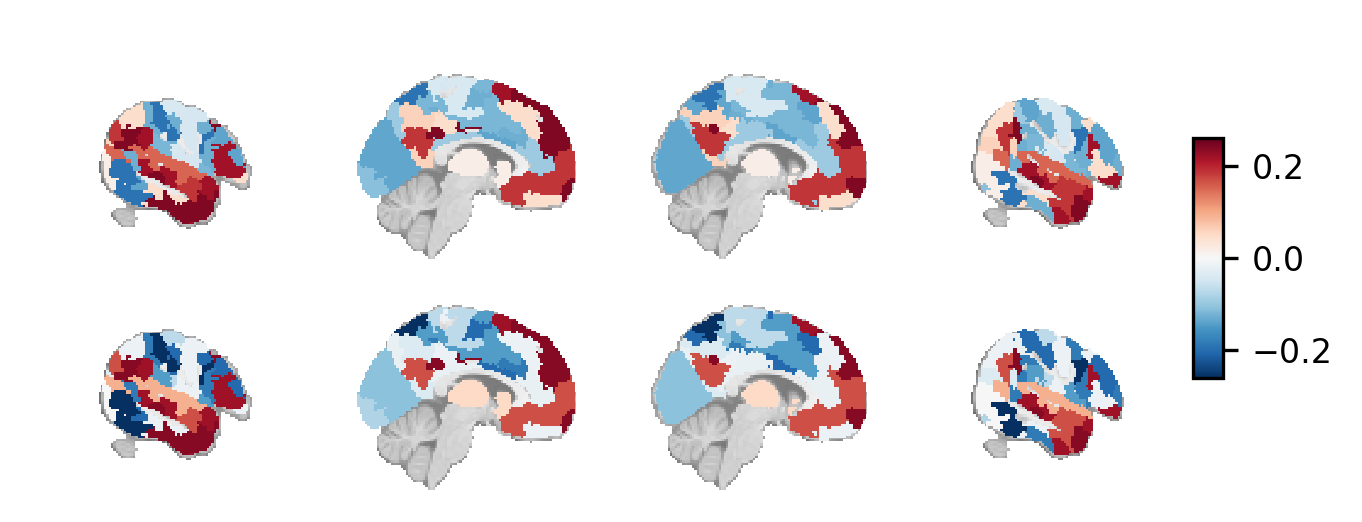

In [41]:
# Plot brain maps for state 1 (index 0)
plot_brain_maps(
    affair_state_brain_maps,
    paranoia_state_brain_maps, 
    SAVE_DIR_FIG2,
    state_num=0,  # For state 1
    state_mapping=state_mapping,
    display_mode=['x'],
    cut_coords=[-55, -5, 5, 55],
    vmax=0.26
)

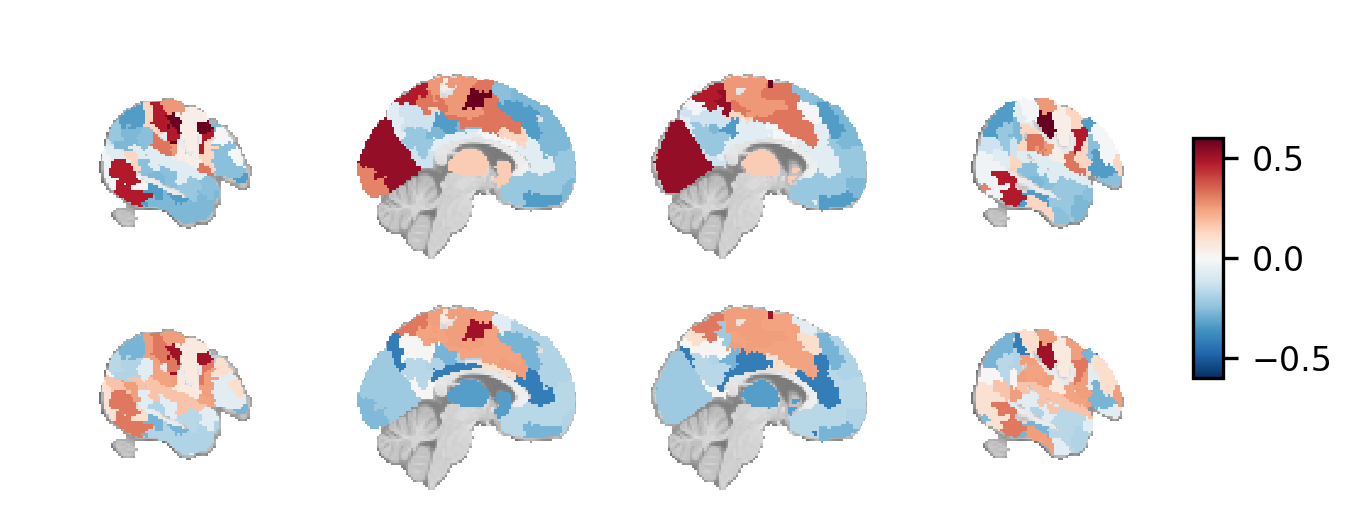

In [42]:
# Plot brain maps for state 1 (index 0)
plot_brain_maps(
    affair_state_brain_maps,
    paranoia_state_brain_maps, 
    SAVE_DIR_FIG2,
    state_num=1,  # For state 1
    state_mapping=state_mapping,
    display_mode=['x'],
    cut_coords=[-55, -5, 5, 55],
    vmax=0.6
)

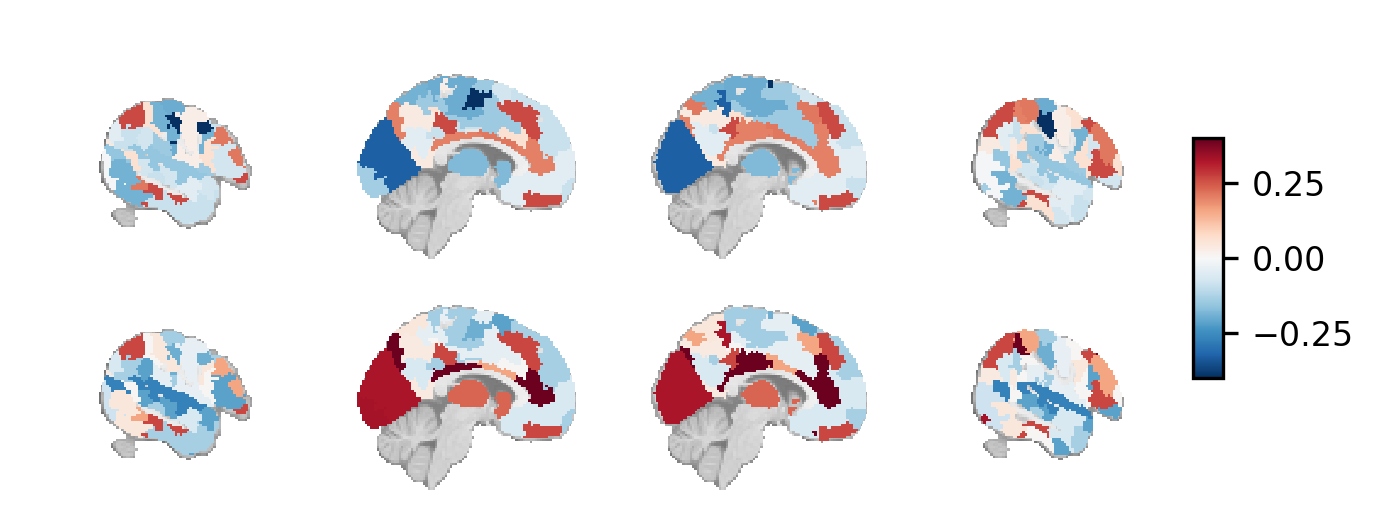

In [43]:
# Plot brain maps for state 1 (index 0)
plot_brain_maps(
    affair_state_brain_maps,
    paranoia_state_brain_maps, 
    SAVE_DIR_FIG2,
    state_num=2,  # For state 1
    state_mapping=state_mapping,
    display_mode=['x'],
    cut_coords=[-55, -5, 5, 55],
    vmax=0.4
)

In [28]:
def plot_paired_state_patterns(affair_properties: Dict, 
                             paranoia_properties: Dict,
                             state_mapping: Dict,
                             state_num: int,  # Add state number parameter
                             **kwargs) -> None:
    """Plot paired state patterns for a single state using bar plots."""
    try:
        network_labels = ['Aud', 'Ctr-A', 'Ctr-B', 'Ctr-C', 'DMN-A', 'DMN-B',
                         'DMN-C', 'DA-A', 'DA-B', 'Lang', 'SVA-A',
                         'SVA-B', 'SM-A', 'SM-B', 'Vis-A', 'Vis-B',
                         'Vis-C', 'Sub']
        
        # Create figure with single subplot
        fig, ax = plt.subplots(figsize=(3, 2))  # Increased height for rotated labels
        
        # Get corresponding states
        affair_props = affair_properties[state_num]
        paranoia_state = state_mapping['affair_to_paranoia'][state_num]
        paranoia_props = paranoia_properties[paranoia_state]
        
        x = np.arange(len(network_labels))
        width = 0.3  # Width of the bars
        
        # Plot affair group as solid bars
        affair_bars = ax.bar(x - width/2, affair_props['mean_pattern'], width,
                           color=COLORS['affair'],
                           label='Affair',
                           alpha=0.8)
        
        # Plot paranoia group as hatched bars
        paranoia_bars = ax.bar(x + width/2, paranoia_props['mean_pattern'], width,
                             color=COLORS['paranoia'],
                             label='Paranoia',
                             alpha=0.8,
                             hatch='////')  # Add hatching for colorblind accessibility
        
        # Add error bars if confidence intervals exist
        if 'mean_pattern_ci' in affair_props:
            ci = affair_props['mean_pattern_ci']
            error = np.array([affair_props['mean_pattern'] - ci['lower'], 
                             ci['upper'] - affair_props['mean_pattern']])
            ax.errorbar(x - width/2, affair_props['mean_pattern'], 
                       yerr=error, fmt='none', ecolor='black', 
                       capsize=1, alpha=0.6)
        
        if 'mean_pattern_ci' in paranoia_props:
            ci = paranoia_props['mean_pattern_ci']
            error = np.array([paranoia_props['mean_pattern'] - ci['lower'], 
                             ci['upper'] - paranoia_props['mean_pattern']])
            ax.errorbar(x + width/2, paranoia_props['mean_pattern'], 
                       yerr=error, fmt='none', ecolor='black', 
                       capsize=1, alpha=0.6)
        
        # Add title and labels
        # ax.set_title(f'State {state_num+1}')
        # ax.set_ylabel('Activation')
        
        # Set fixed y-axis limits
        ax.set_ylim(-0.6, 0.6)  # Set appropriate min and max values
        
        # Set axis labels and ticks
        ax.set_xticks(x)
        ax.set_xticklabels(network_labels, rotation=90)  # Rotate labels 90 degrees
        
        # Remove the x-axis tick marks but keep the labels
        ax.tick_params(axis='x', which='both', length=0)
        
        # Add a horizontal line at y=0 for reference
        ax.axhline(y=0, color='black', alpha=1, linewidth=0.5)
        
        ax.grid(True, axis='y', alpha=0.3)
        # ax.legend()
        
        # Adjust layout to make room for rotated labels
        plt.tight_layout()
        plt.show()
        save_figure(fig, SAVE_DIR_FIG2, f"paired_state_{state_num+1}_patterns_bar")
        
    except Exception as e:
        print(f"Error plotting paired state patterns: {e}")
        raise

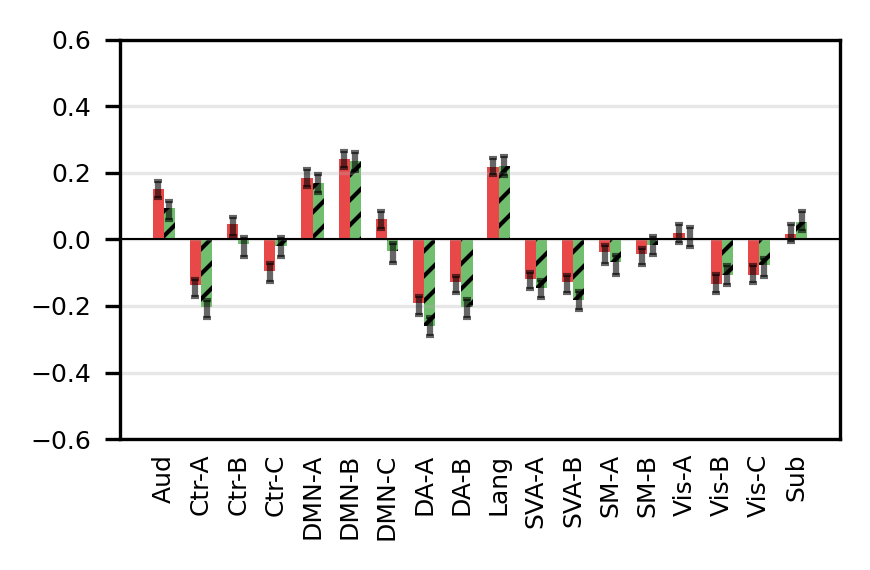

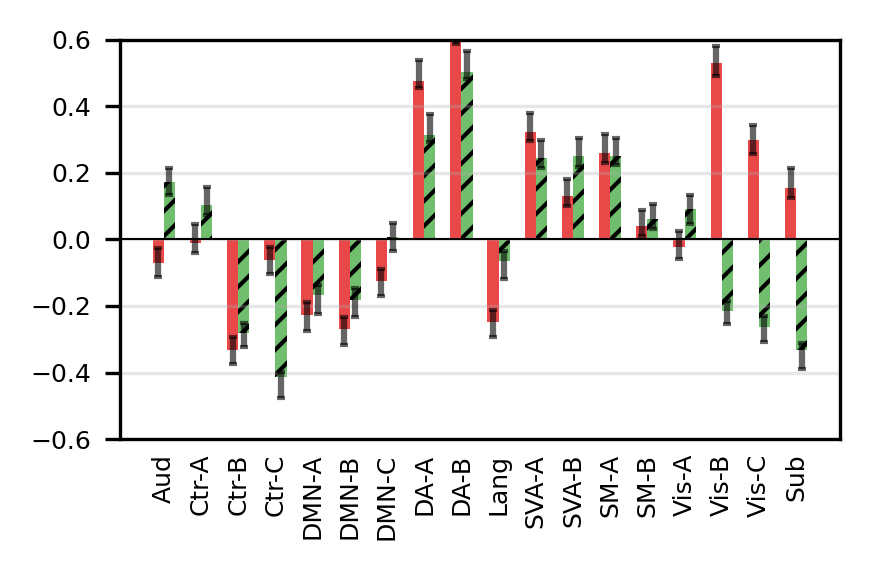

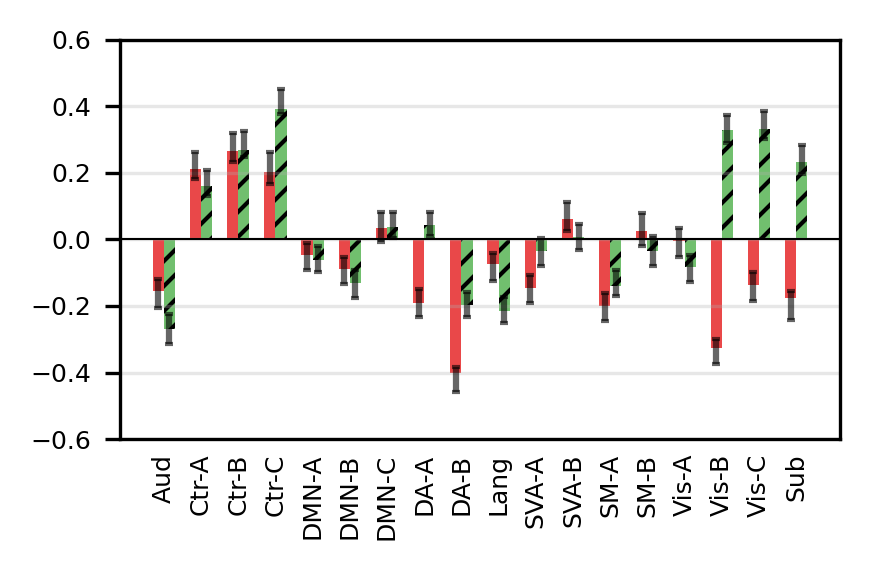

In [29]:
# Plot each state pair separately
for state in range(n_states):
    plot_paired_state_patterns(
        affair_result['metrics']['state_properties'],
        paranoia_result['metrics']['state_properties'],
        state_mapping,
        state_num=state
    )

In [72]:
def plot_paired_state_patterns(affair_properties: Dict, 
                             paranoia_properties: Dict,
                             state_mapping: Dict,
                             states_to_plot: List[int],
                             **kwargs) -> None:
    """
    Plot multiple paired state patterns with networks on y-axis and activation on x-axis.
    
    Parameters:
    -----------
    affair_properties: Dict
        Properties of states for the affair group
    paranoia_properties: Dict
        Properties of states for the paranoia group
    state_mapping: Dict
        Mapping between affair and paranoia states
    states_to_plot: List[int]
        List of state numbers to plot (usually 3 states)
    """
    try:
        # Reverse the order of network labels
        network_labels = ['Auditory', 'ContA', 'ContB', 'ContC', 'DefaultA', 'DefaultB',
                         'DefaultC', 'DorsAttnA', 'DorsAttnB', 'Language', 'SalVenAttnA',
                         'SalVenAttnB', 'SomMotA', 'SomMotB', 'VisualA', 'VisualB',
                         'VisualC', 'Subcortex']
        network_labels.reverse()  # Reverse the order
        
        # Create figure with subplots - one per state
        fig, axes = plt.subplots(1, len(states_to_plot), figsize=(21, 18), sharey=False)  # Changed sharey to False
        
        # Make axes a list if only one subplot is created
        if len(states_to_plot) == 1:
            axes = [axes]
            
        # Add a common y-axis label
        # fig.supylabel('Brain Networks', fontsize=16)
        
        for idx, state_num in enumerate(states_to_plot):
            ax = axes[idx]
            
            # Get corresponding states
            affair_props = affair_properties[state_num]
            paranoia_state = state_mapping['affair_to_paranoia'][state_num]
            paranoia_props = paranoia_properties[paranoia_state]
            
            # Create y positions and reverse the data patterns to match the reversed labels
            y = np.arange(len(network_labels))
            
            # Create copies of the patterns and reverse them
            affair_pattern = affair_props['mean_pattern'].copy()
            affair_pattern = affair_pattern[::-1]  # Reverse the array
            
            paranoia_pattern = paranoia_props['mean_pattern'].copy()
            paranoia_pattern = paranoia_pattern[::-1]  # Reverse the array
            
            # Bar width and offset for grouped bars
            bar_width = 0.4
            offset = bar_width / 2
            
            # Plot affair group as bars (using reversed data)
            affair_bars = ax.barh(y - offset, affair_pattern, height=bar_width,
                    color=COLORS['affair'],
                    label='Affair',
                    alpha=0.7)
            
            # Plot paranoia group as bars (using reversed data)
            paranoia_bars = ax.barh(y + offset, paranoia_pattern, height=bar_width,
                    color=COLORS['paranoia'],
                    label='Paranoia',
                    alpha=0.7)
            
            # Add error bars if confidence intervals exist (using reversed data)
            if 'mean_pattern_ci' in affair_props:
                ci = affair_props['mean_pattern_ci']
                # Reverse the confidence intervals
                lower = ci['lower'][::-1]
                upper = ci['upper'][::-1]
                error = np.array([affair_pattern - lower, upper - affair_pattern])
                ax.errorbar(affair_pattern, y - offset, 
                           xerr=error, fmt='none', ecolor=COLORS['affair'], 
                           capsize=3, alpha=0.8)
            
            if 'mean_pattern_ci' in paranoia_props:
                ci = paranoia_props['mean_pattern_ci']
                # Reverse the confidence intervals
                lower = ci['lower'][::-1]
                upper = ci['upper'][::-1]
                error = np.array([paranoia_pattern - lower, upper - paranoia_pattern])
                ax.errorbar(paranoia_pattern, y + offset, 
                           xerr=error, fmt='none', ecolor=COLORS['paranoia'], 
                           capsize=3, alpha=0.8)
            
            # Add title with less padding
            ax.set_title(f'State {state_num+1}', fontsize=20, pad=5)
            
            # Only add x-label for each subplot
            ax.set_xlabel('Activation', fontsize=18)
            
            # Add a vertical line at x=0 for reference
            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
            
            # Set grid and legend for each subplot
            ax.grid(True, alpha=0.3)
            
            # Configure y-axis ticks and labels for each subplot
            ax.set_yticks(y)
            if idx == 0:
                # Force y-ticklabels to be visible for the first subplot
                labels = ax.set_yticklabels(network_labels, fontsize=16)
                # Make sure they are visible
                for label in labels:
                    label.set_visible(True)
                ax.tick_params(axis='y', pad=5)
            else:
                # Hide ticklabels for other subplots but maintain the same y range
                ax.set_yticklabels([])
                # Match the ylim to ensure all plots have the same scale
                ax.set_ylim(axes[0].get_ylim())
            
            ax.tick_params(axis='x', labelsize=18)
            
            # Make sure all subplots share the y range
            if idx > 0:
                ax.set_ylim(axes[0].get_ylim())
        
        # Manually align subplots since we're not using sharey=True
        for ax in axes[1:]:
            ax.set_ylim(axes[0].get_ylim())
        
        # Add legend to the last (third) plot instead of at the bottom
        if len(states_to_plot) >= 3:
            last_ax = axes[2]  # Third plot (index 2)
            last_ax.legend(fontsize=18, loc='center right', framealpha=0.9)
        else:
            # If fewer than 3 plots, use the last available one
            last_ax = axes[-1]
            last_ax.legend(fontsize=18, loc='center right', framealpha=0.9)
        
        # Adjust the subplot layout to make sure everything fits
        plt.tight_layout()
        
        # Apply constrained_layout after tight_layout to fix spacing
        fig.set_constrained_layout(True)
        
        plt.show()
        
        # Save the figure
        save_figure(fig, SAVE_DIR_FIG2, f"paired_states_{'_'.join([str(s+1) for s in states_to_plot])}")
        
    except Exception as e:
        print(f"Error plotting paired state patterns: {e}")
        raise

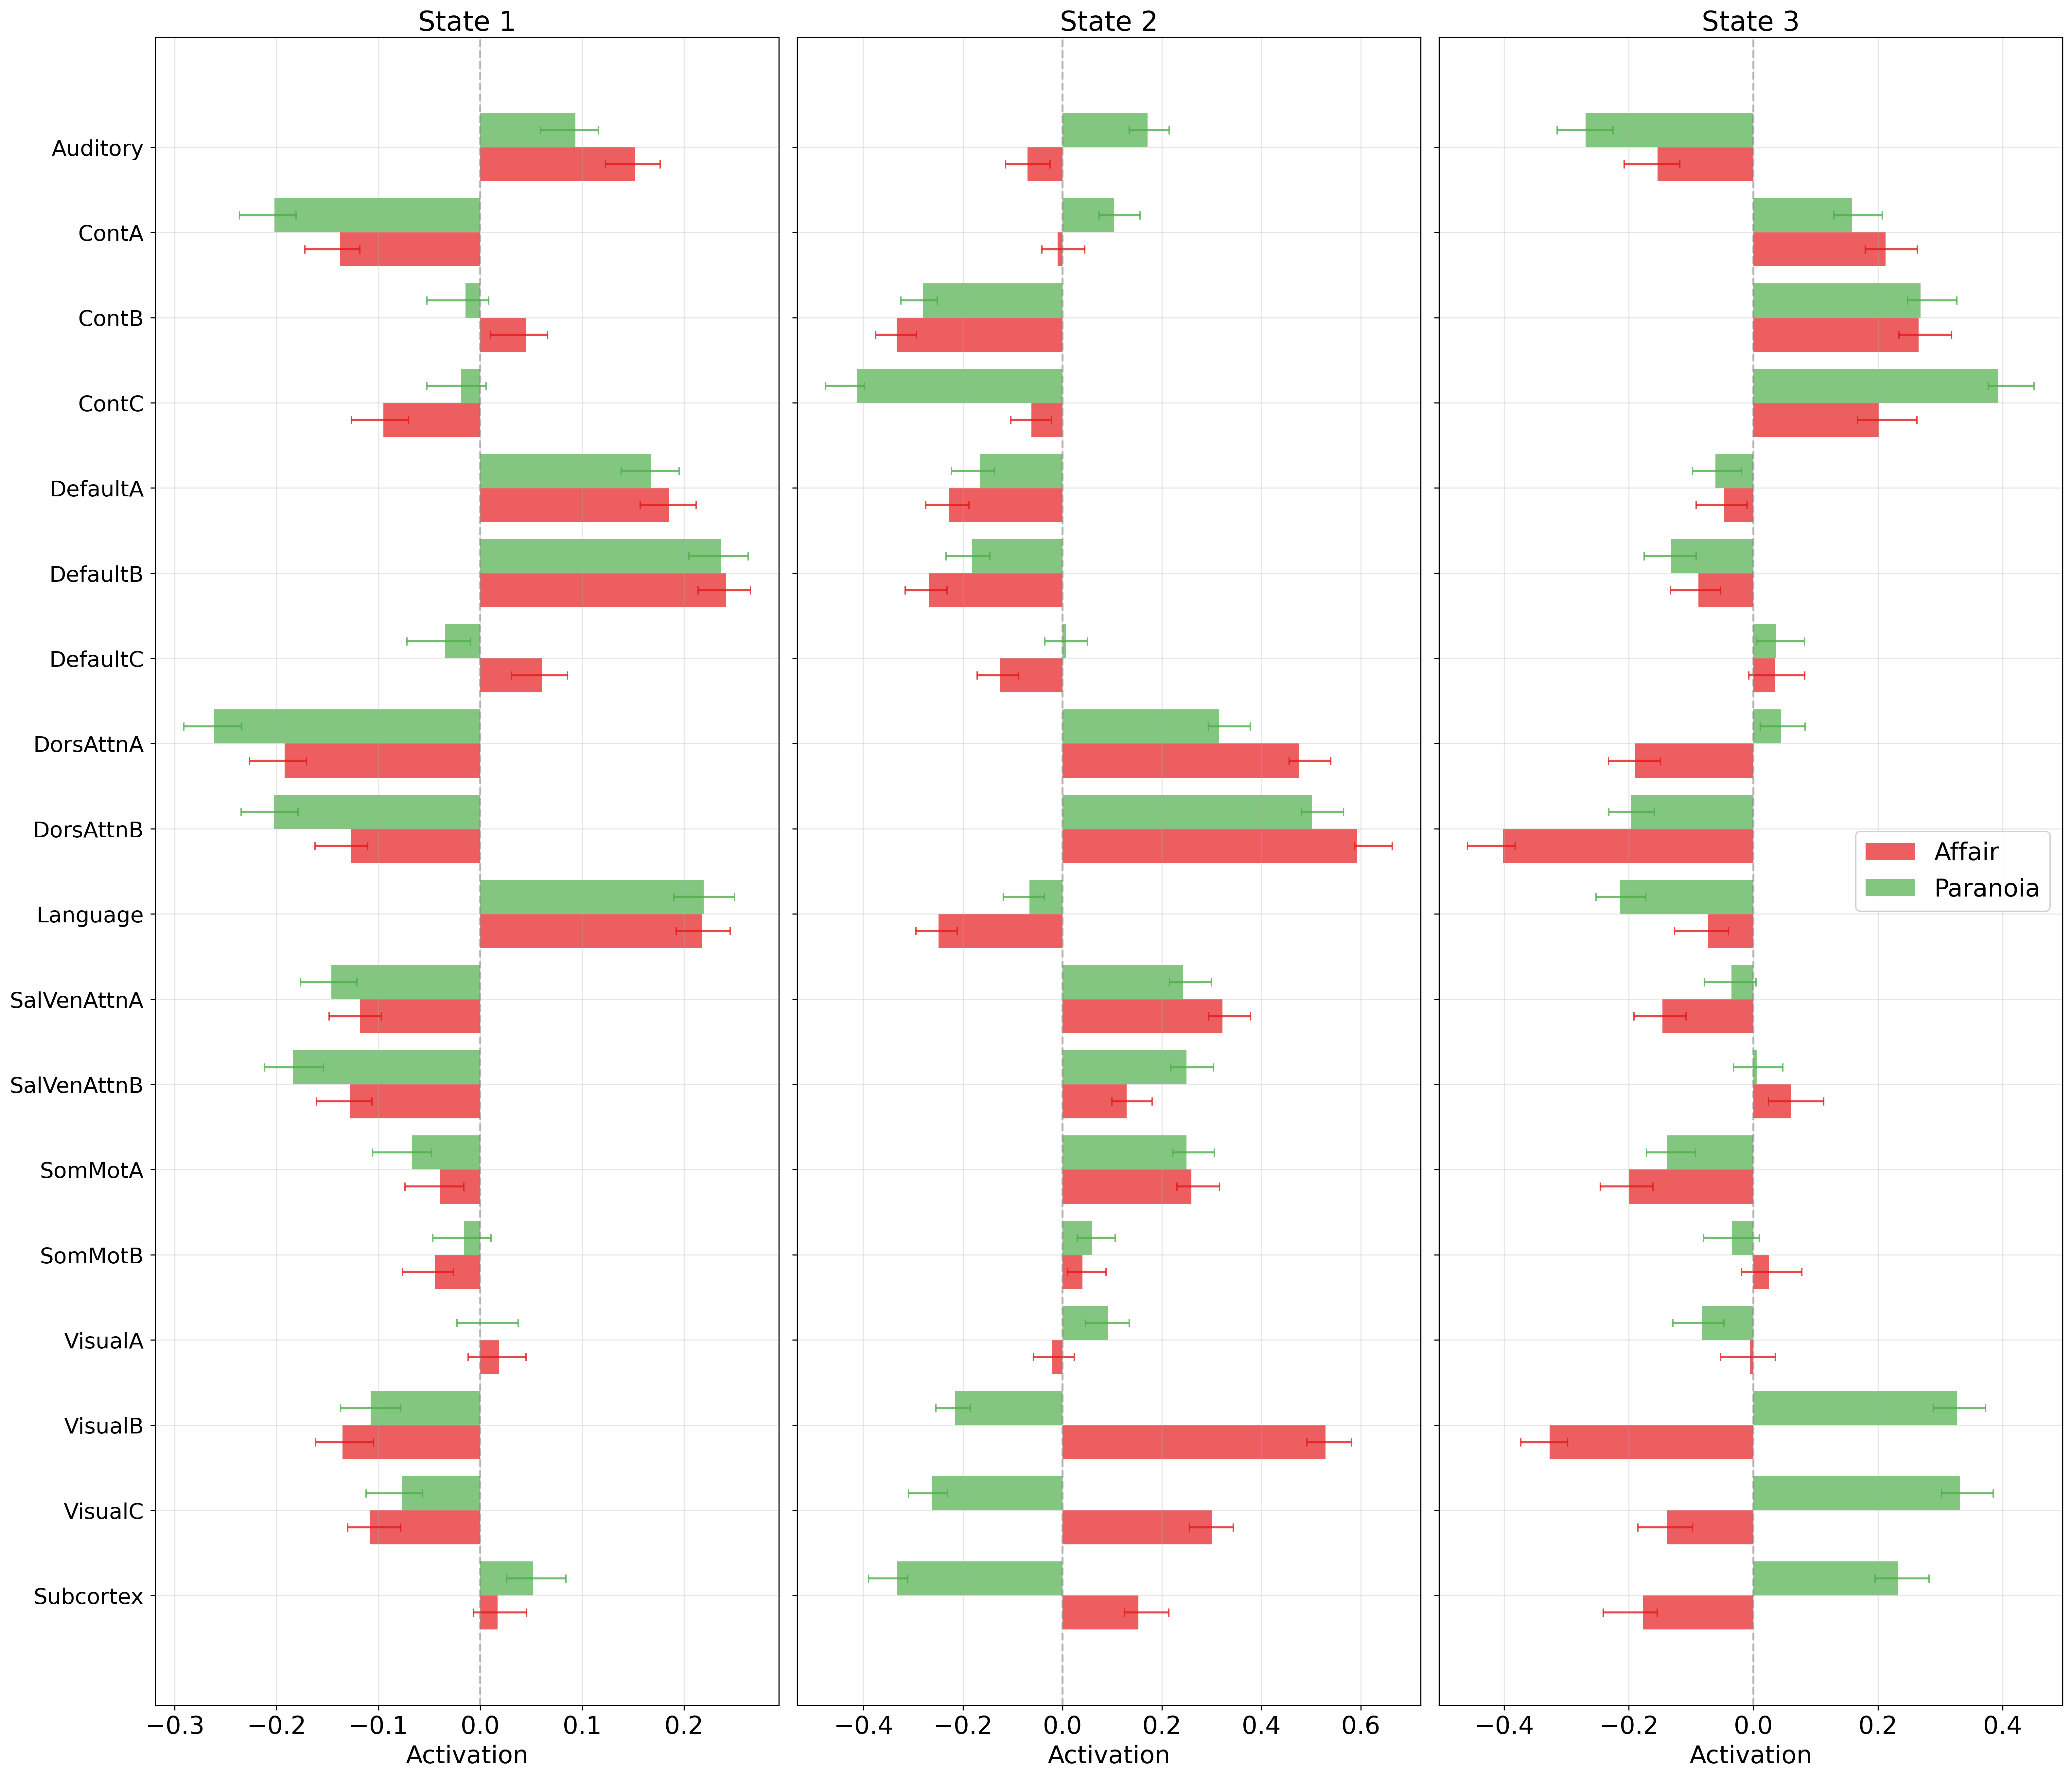

In [18]:
plot_paired_state_patterns(affair_result['metrics']['state_properties'], paranoia_result['metrics']['state_properties'], state_mapping, [0, 1, 2])

In [26]:
affair_result['metrics']['subject_consistency'].keys()

dict_keys(['state_frequency', 'pattern_correlation', 'timing_correlation', 'similarity_metrics', 'summary'])

In [10]:
affair_result['metrics']['state_metrics'].keys()

dict_keys(['subject_level', 'group_level', 'temporal', 'uncertainty'])

In [18]:
affair_result['metrics']['state_metrics']['group_level'].keys()

dict_keys(['durations', 'transitions', 'frequencies', 'fractional_occupancy', 'frequencies_ci', 'fractional_occupancy_ci', 'transition_entropy'])

In [20]:
affair_result['metrics']['state_metrics']['group_level']['fractional_occupancy']

array([0.434123  , 0.28323025, 0.28264675])

In [11]:
paranoia_result['metrics']['state_metrics']['group_level']['fractional_occupancy']

array([0.31543937, 0.40704866, 0.27751196])

In [12]:
affair_result['metrics']['state_metrics']['subject_level'][0]['fractional_occupancy']

array([0.40354767, 0.26829268, 0.32815965])

In [12]:
affair_result['metrics']['state_metrics']['temporal'].keys()

dict_keys(['switching_rate', 'state_mixing', 'recurrence_intervals', 'state_stability', 'entropy_rate', 'summary', 'raw'])

In [33]:
affair_result['metrics']['state_metrics']['temporal']['raw']['switching_rates']

array([0.13451589, 0.09016999, 0.07834442, 0.10643016, 0.10347376,
       0.09903917, 0.07538803, 0.10051737, 0.07095344, 0.12121212,
       0.09756098, 0.0872136 , 0.10790835, 0.10347376, 0.10643016,
       0.11234294, 0.07834442, 0.0872136 , 0.07538803])

In [34]:
paranoia_result['metrics']['state_metrics']['temporal']['raw']['switching_rates']

array([0.10495196, 0.10495196, 0.10643016, 0.0886918 , 0.08130081,
       0.09903917, 0.09460458, 0.10495196, 0.11234294, 0.05764967,
       0.11677753, 0.0872136 , 0.10199557, 0.10199557, 0.10790835,
       0.10051737, 0.10495196, 0.11234294, 0.08277901])

In [13]:
affair_result['metrics']['state_metrics']['uncertainty'].keys()

dict_keys(['state_occupancy', 'transition_rates', 'temporal_metrics'])

In [14]:
affair_result['metrics']['state_metrics']['uncertainty']['state_occupancy'][0].keys()

dict_keys(['ci_lower', 'ci_upper', 'std'])

In [15]:
affair_result['metrics']['state_properties'].keys()

dict_keys([0, 1, 2, 'separability'])

In [16]:
affair_result['metrics']['state_properties'][0].keys()

dict_keys(['mean_pattern', 'mean_pattern_ci', 'std_pattern', 'cv_pattern', 'covariance', 'correlation', 'effective_dimension', 'feature_importance', 'top_features', 'pattern_stability'])

In [17]:
affair_result['metrics']['state_properties']['separability'].keys()

dict_keys(['pairwise_distances', 'confusion_matrix', 'mahalanobis_distances', 'bootstrap_metrics', 'summary'])

In [54]:
state_mapping = {
    'affair_to_paranoia': {0: 1, 1: 2, 2: 0},  # affair state 0 maps to paranoia state 1, etc.
    'paranoia_to_affair': {1: 0, 2: 1, 0: 2}   # paranoia state 1 maps to affair state 0, etc.
}

In [57]:
def compare_state_temporal_dynamics(affair_data, paranoia_data, state_mapping):
    """Compare temporal dynamics of aligned states between groups."""
    results = {}
    
    # Duration statistics comparison
    for affair_state, paranoia_state in state_mapping['affair_to_paranoia'].items():
        # Collect durations for each subject in each group
        affair_durations = [subj['duration_stats'][affair_state]['mean'] 
                           for subj in affair_data['subject_level'].values()]
        paranoia_durations = [subj['duration_stats'][paranoia_state]['mean'] 
                             for subj in paranoia_data['subject_level'].values()]
        
        # Statistical test
        t_stat, p_value = stats.ttest_ind(affair_durations, paranoia_durations)
        
        # Calculate effect size (Cohen's d)
        effect_size = (np.mean(paranoia_durations) - np.mean(affair_durations)) / \
                     np.sqrt((np.std(paranoia_durations)**2 + np.std(affair_durations)**2) / 2)
        
        results[f'state_{affair_state}_vs_{paranoia_state}'] = {
            'affair_mean_duration': np.mean(affair_durations),
            'paranoia_mean_duration': np.mean(paranoia_durations),
            'p_value': p_value,
            'effect_size': effect_size
        }
    
    return results

In [62]:
temporal_results = compare_state_temporal_dynamics(affair_result['metrics']['state_metrics'], paranoia_result['metrics']['state_metrics'], state_mapping)
temporal_results

{'state_0_vs_1': {'affair_mean_duration': 11.937386573477127,
  'paranoia_mean_duration': 11.306402650375679,
  'p_value': 0.7083877942290828,
  'effect_size': -0.12566624034807988},
 'state_1_vs_2': {'affair_mean_duration': 9.069103707497838,
  'paranoia_mean_duration': 8.187279324150428,
  'p_value': 0.06454675033011979,
  'effect_size': -0.6356130020496726},
 'state_2_vs_0': {'affair_mean_duration': 9.406109066102157,
  'paranoia_mean_duration': 10.163984441900576,
  'p_value': 0.31602083042620616,
  'effect_size': 0.3389425216441241}}

In [63]:
def compare_state_patterns(affair_states, paranoia_states, state_mapping):
    """Compare neural patterns of aligned states between groups."""
    results = {}
    
    for affair_state, paranoia_state in state_mapping['affair_to_paranoia'].items():
        # Get state patterns
        affair_pattern = affair_states[affair_state]['mean_pattern']
        paranoia_pattern = paranoia_states[paranoia_state]['mean_pattern']
        
        # Calculate similarity
        pattern_corr = np.corrcoef(affair_pattern, paranoia_pattern)[0, 1]
        
        # Compare feature importance
        affair_features = affair_states[affair_state]['top_features']['indices']
        paranoia_features = paranoia_states[paranoia_state]['top_features']['indices']
        shared_features = set(affair_features).intersection(set(paranoia_features))
        
        results[f'state_{affair_state}_vs_{paranoia_state}'] = {
            'pattern_correlation': pattern_corr,
            'affair_dimension': affair_states[affair_state]['effective_dimension'],
            'paranoia_dimension': paranoia_states[paranoia_state]['effective_dimension'],
            'shared_important_features': len(shared_features),
            'affair_stability': affair_states[affair_state]['pattern_stability'],
            'paranoia_stability': paranoia_states[paranoia_state]['pattern_stability']
        }
    
    return results

In [64]:
pattern_results = compare_state_patterns(affair_result['metrics']['state_properties'], paranoia_result['metrics']['state_properties'], state_mapping)
pattern_results

{'state_0_vs_1': {'pattern_correlation': 0.9451349704767232,
  'affair_dimension': 3.5097216681838495,
  'paranoia_dimension': 3.634608579670044,
  'shared_important_features': 10,
  'affair_stability': 0.9781190529234535,
  'paranoia_stability': 0.9897357407406784},
 'state_1_vs_2': {'pattern_correlation': 0.46798008803648633,
  'affair_dimension': 5.104726977346941,
  'paranoia_dimension': 5.029674821163042,
  'shared_important_features': 7,
  'affair_stability': 0.9726470864932794,
  'paranoia_stability': 0.9766442608990831},
 'state_2_vs_0': {'pattern_correlation': 0.33331942206505116,
  'affair_dimension': 4.595835500805606,
  'paranoia_dimension': 6.282833602307736,
  'shared_important_features': 8,
  'affair_stability': 0.9689666069538728,
  'paranoia_stability': 0.9185088407979235}}

In [65]:
def compare_transition_dynamics(affair_data, paranoia_data, state_mapping):
    """Compare state transition patterns between groups."""
    results = {}
    
    # Calculate average transition matrices for each group
    affair_transitions = np.mean([subj['transitions'] for subj in affair_data['subject_level'].values()], axis=0)
    paranoia_transitions = np.mean([subj['transitions'] for subj in paranoia_data['subject_level'].values()], axis=0)
    
    # Align paranoia transitions to affair state order
    paranoia_aligned = np.zeros_like(paranoia_transitions)
    for i in range(3):
        for j in range(3):
            paranoia_i = state_mapping['affair_to_paranoia'][i]
            paranoia_j = state_mapping['affair_to_paranoia'][j]
            paranoia_aligned[i, j] = paranoia_transitions[paranoia_i, paranoia_j]
    
    # Calculate transition differences
    transition_diff = paranoia_aligned - affair_transitions
    
    # Calculate transition entropy for each state
    affair_entropy = [-np.sum(affair_transitions[i] * np.log(affair_transitions[i] + 1e-10)) 
                     for i in range(3)]
    paranoia_entropy = [-np.sum(paranoia_aligned[i] * np.log(paranoia_aligned[i] + 1e-10)) 
                       for i in range(3)]
    
    results = {
        'affair_transitions': affair_transitions,
        'paranoia_aligned': paranoia_aligned,
        'transition_diff': transition_diff,
        'affair_entropy': affair_entropy,
        'paranoia_entropy': paranoia_entropy
    }
    
    return results

In [66]:
transition_results = compare_transition_dynamics(affair_result['metrics']['state_metrics'], paranoia_result['metrics']['state_metrics'], state_mapping)
transition_results
    


{'affair_transitions': array([[0.        , 0.59312083, 0.40687917],
        [0.56319933, 0.        , 0.43680067],
        [0.69559695, 0.30440305, 0.        ]]),
 'paranoia_aligned': array([[0.        , 0.54521115, 0.45478885],
        [0.61731935, 0.        , 0.38268065],
        [0.56960794, 0.43039206, 0.        ]]),
 'transition_diff': array([[ 0.        , -0.04790968,  0.04790968],
        [ 0.05412003,  0.        , -0.05412003],
        [-0.12598902,  0.12598902,  0.        ]]),
 'affair_entropy': [0.6757025247284174, 0.6851374621811666, 0.614548963601129],
 'paranoia_entropy': [0.6890534950467997,
  0.6653611956536445,
  0.6834251032629806]}

In [67]:
def compare_subject_consistency(affair_data, paranoia_data, state_mapping):
    """Compare how consistently states appear across subjects in each group."""
    # Extract fractional occupancy for each subject in each group
    affair_occupancy = np.array([list(subj['fractional_occupancy']) 
                               for subj in affair_data['subject_level'].values()])
    paranoia_occupancy = np.array([list(subj['fractional_occupancy']) 
                                 for subj in paranoia_data['subject_level'].values()])
    
    # Align paranoia occupancy to affair state order
    paranoia_aligned = np.zeros_like(paranoia_occupancy)
    for i in range(3):
        paranoia_i = state_mapping['affair_to_paranoia'][i]
        paranoia_aligned[:, i] = paranoia_occupancy[:, paranoia_i]
    
    # Calculate variance across subjects for each state
    affair_variance = np.var(affair_occupancy, axis=0)
    paranoia_variance = np.var(paranoia_aligned, axis=0)
    
    # Calculate average pairwise correlation between subjects
    affair_correlations = []
    paranoia_correlations = []
    
    for i in range(len(affair_occupancy)):
        for j in range(i+1, len(affair_occupancy)):
            affair_correlations.append(np.corrcoef(affair_occupancy[i], affair_occupancy[j])[0, 1])
    
    for i in range(len(paranoia_aligned)):
        for j in range(i+1, len(paranoia_aligned)):
            paranoia_correlations.append(np.corrcoef(paranoia_aligned[i], paranoia_aligned[j])[0, 1])
    
    return {
        'affair_state_variance': affair_variance,
        'paranoia_state_variance': paranoia_variance,
        'affair_subject_correlation': np.mean(affair_correlations),
        'paranoia_subject_correlation': np.mean(paranoia_correlations)
    }

In [69]:
consistency_results = compare_subject_consistency(affair_result['metrics']['state_metrics'], paranoia_result['metrics']['state_metrics'], state_mapping)
consistency_results

{'affair_state_variance': array([0.0236078 , 0.00456026, 0.0123093 ]),
 'paranoia_state_variance': array([0.02859393, 0.00479595, 0.01243271]),
 'affair_subject_correlation': 0.1872488137562338,
 'paranoia_subject_correlation': 0.10842534819789874}